In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models import *
from tqdm.notebook import tnrange, tqdm
from datetime import datetime

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    with tqdm(trainloader) as tepoch:
        tepoch.set_description(f"Training Epoch {epoch}")
        for batch_idx, (inputs, targets) in enumerate(tepoch):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            tepoch.set_postfix(loss= '{:.2f}'.format(train_loss / (batch_idx + 1)), acc='{:.2f}%'.format(100.*correct/total))
        return train_loss / (batch_idx + 1), 100.*correct/total

In [5]:
# Test
def test_res(epoch, save_name):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(testloader) as tepoch:
            tepoch.set_description(f"Testing Epoch {epoch}")
            for batch_idx, (inputs, targets) in enumerate(tepoch):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                tepoch.set_postfix(loss='{:.2f}'.format(test_loss / (batch_idx + 1)), acc='{:.2f}%'.format(100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + save_name + '.pth')
        best_acc = acc
    return test_loss / (batch_idx + 1), 100.*correct/total

In [11]:
net = ResNet(BasicBlock, [1, 1, 1, 1])
net = net.to(device)
print("Total Parameters:", sum(p.numel() for p in net.parameters()))

Total Parameters: 4903242


In [12]:
best_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

In [13]:
# Execute Training
train_data = []
test_data = []
for epoch in tnrange(60, desc='Training and Testing Epochs'):
    train_d = train(epoch)
    train_data.append(train_d)
    test_d = test_res(epoch, 'resnet_self_define')
    test_data.append(test_d)
    scheduler.step()

Training and Testing Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x146831b98f70>Exception ignored in: 
Traceback (most recent call last):
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x146831b98f70>Traceback (most recent call last):
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/share/apps/python/3.8.6/intel/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

AssertionError  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
: can only te

  0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x146831b98f70>
Traceback (most recent call last):
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/share/apps/python/3.8.6/intel/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x146831b98f70>    
Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in 

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x146831b98f70>
Traceback (most recent call last):
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/share/apps/python/3.8.6/intel/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x146831b98f70>
Traceback (most recent call last):
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/home/ly2279/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

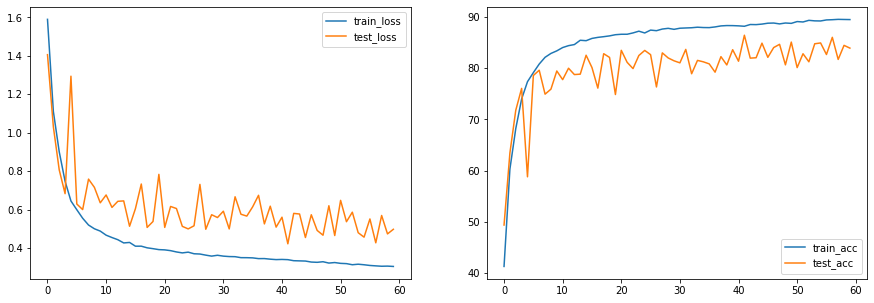

In [14]:
import matplotlib.pyplot as plt
losses = [item[0] for item in train_data]
tlosses = [item[0] for item in test_data]
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses, label='train_loss')
axs[0].plot(tlosses, label='test_loss')
fig.set_size_inches(15, 5)
axs[0].legend()

tacces = [item[1] for item in test_data]
acces = [item[1] for item in train_data]
axs[1].plot(acces, label='train_acc')
axs[1].plot(tacces, label='test_acc')
axs[1].legend()

plt.show()

In [15]:
print("Training Acc: ", max(acces), "Testing Acc: ", max(tacces))

Training Acc:  89.552 Testing Acc:  86.45


In [7]:
net = ResNet(BasicBlock, [1, 1, 1, 1])
net = net.to(device)
print("Total Parameters:", sum(p.numel() for p in net.parameters()))

Total Parameters: 4903242


In [8]:
best_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

In [9]:
train_data = []
test_data = []
for epoch in tnrange(60, desc='Training and Testing Epochs'):
    train_d = train(epoch)
    train_data.append(train_d)
    test_d = test_res(epoch, 'resnet_self_define_adam')
    test_data.append(test_d)
    scheduler.step()

Training and Testing Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


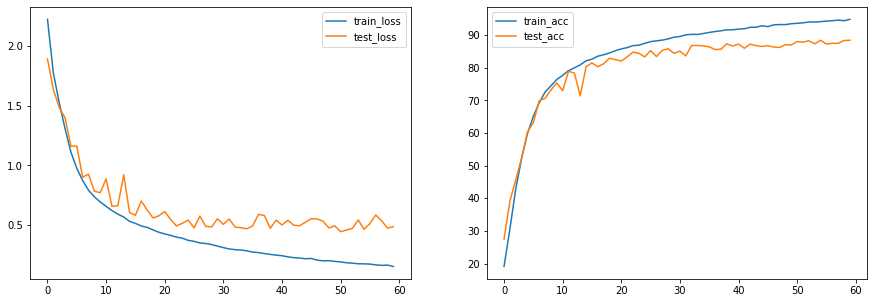

In [10]:
import matplotlib.pyplot as plt
losses = [item[0] for item in train_data]
tlosses = [item[0] for item in test_data]
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses, label='train_loss')
axs[0].plot(tlosses, label='test_loss')
fig.set_size_inches(15, 5)
axs[0].legend()

tacces = [item[1] for item in test_data]
acces = [item[1] for item in train_data]
axs[1].plot(acces, label='train_acc')
axs[1].plot(tacces, label='test_acc')
axs[1].legend()

plt.show()

In [11]:
print("Training Acc: ", max(acces), "Testing Acc: ", max(tacces))

Training Acc:  94.818 Testing Acc:  88.42


# Method 2

In [16]:
class MyResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(MyResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [32]:
net = MyResNet(BasicBlock, [2, 2, 2, 2])
net = net.to(device)
print("Total Parameters:", sum(p.numel() for p in net.parameters()))

Total Parameters: 1891658


In [22]:
best_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

In [23]:
train_data = []
test_data = []
for epoch in tnrange(60, desc='Training and Testing Epochs'):
    train_d = train(epoch)
    train_data.append(train_d)
    A
    test_d = test_res(epoch, 'resnet_self_define_adam')
    test_data.append(test_d)
    scheduler.step()

Training and Testing Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

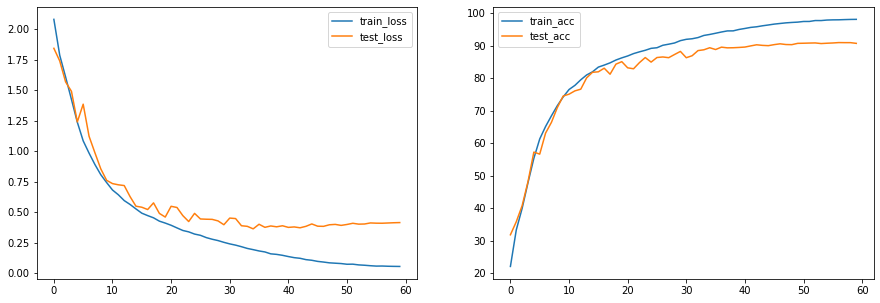

In [24]:
import matplotlib.pyplot as plt
losses = [item[0] for item in train_data]
tlosses = [item[0] for item in test_data]
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses, label='train_loss')
axs[0].plot(tlosses, label='test_loss')
fig.set_size_inches(15, 5)
axs[0].legend()

tacces = [item[1] for item in test_data]
acces = [item[1] for item in train_data]
axs[1].plot(acces, label='train_acc')
axs[1].plot(tacces, label='test_acc')
axs[1].legend()

plt.show()

In [25]:
print("Training Acc: ", max(acces), "Testing Acc: ", max(tacces))

Training Acc:  98.132 Testing Acc:  90.98


In [30]:
net = MyResNet(BasicBlock, [2, 2, 2, 2])
net = net.to(device)
best_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

In [31]:
train_data = []
test_data = []
for epoch in tnrange(60, desc='Training and Testing Epochs'):
    train_d = train(epoch)
    train_data.append(train_d)
    test_d = test_res(epoch, 'resnet_self_define_adam')
    test_data.append(test_d)
    scheduler.step()

Training and Testing Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

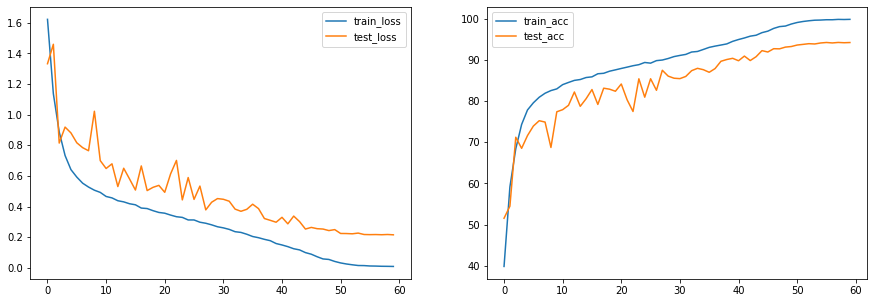

In [33]:
import matplotlib.pyplot as plt
losses = [item[0] for item in train_data]
tlosses = [item[0] for item in test_data]
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses, label='train_loss')
axs[0].plot(tlosses, label='test_loss')
fig.set_size_inches(15, 5)
axs[0].legend()

tacces = [item[1] for item in test_data]
acces = [item[1] for item in train_data]
axs[1].plot(acces, label='train_acc')
axs[1].plot(tacces, label='test_acc')
axs[1].legend()

plt.show()

In [34]:
print("Training Acc: ", max(acces), "Testing Acc: ", max(tacces))

Training Acc:  99.812 Testing Acc:  94.21
